In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## 1. Functions that we will use in the next steps

In [119]:
#get profile distribution
def get_user_profile_distribution(df, user):
    user_profile_distribution = {}
    n = 0
    for item in df[df['userId'] == user]['itemId'].values:

        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1
            
    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    return user_profile_distribution

In [121]:
#get distribution of the recomendation
def get_user_recommendation_distribution(prediction_user_map):
    user_rec_distribution = {}
    n = 0
    for (item, score) in prediction_user_map:
        for genre in genre_map[item]:
            if genre not in user_rec_distribution:
                user_rec_distribution[genre] = 0
            n += 1
            user_rec_distribution[genre] += 1
            
    user_rec_distribution = {k: v/n for k, v in sorted(user_rec_distribution.items(), key=lambda item: item[1])}
    return user_rec_distribution

In [123]:
#metrica para medir cuan injusto fueron las recomendaciones respecto del perfil del usuario
def user_rank_miscalibration(user_profile_dist, rec_profile_dist, alpha=0.001):
    p_g_u = user_profile_dist
    q_g_u = rec_profile_dist
    
    Ckl = 0
    for genre, p in p_g_u.items():
        q = q_g_u.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if til_q == 0 or p_g_u.get(genre, 0) == 0:
            Ckl = Ckl
        else:
            Ckl += p * np.log2(p / til_q)
    return Ckl

def get_mean_rank_miscalibration(predictions):
    
    MRMC = 0
    
    for user in predictions:
        RMC = 0
        user_profile_dist = get_user_profile_distribution(train_df, user)
        if user_profile_dist == {}:
            continue
        
        void = user_rank_miscalibration(user_profile_dist, {})
        N = len(predictions[user])
        for i in range(1, N):
            user_rec_dist = get_user_recommendation_distribution(predictions[user][:i])
            kl = user_rank_miscalibration(user_profile_dist, user_rec_dist)
            RMC += kl/void

        MRMC += RMC/N
    
    return MRMC/len(predictions)

In [125]:
#metricas para avaliar
def item_is_relevant(userId, itemId):
    aux = train_df[train_df["userId"] == userId]
    if itemId in list(aux['itemId']):
        return True
    return False

def calculate_MRR(map_recommendations):

    MRR = 0
    for userId in map_recommendations:
        user_find_corerect_item = False
        for index, (itemId, score) in enumerate(map_recommendations[userId]):
            if user_find_corerect_item is False:
                if item_is_relevant(userId, itemId):
                    MRR += (1/(index+1))
                    user_find_corerect_item = True
        
    return MRR/len(map_recommendations)


In [127]:
#funciones para calcuar la calibracion
def calculate_calibration_sum(profile_dist, temporary_list_with_score, user, alpha=0.001):
    kl_div = 0.0
    reco_distr = get_user_recommendation_distribution(temporary_list_with_score)
    for genre, p in profile_dist.items():
        q = reco_distr.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if p == 0.0 or til_q == 0.0:
            kl_div = kl_div
        else:
            kl_div = kl_div + (p * np.log2(p / til_q))
    return kl_div


def rerank_recommendation(profile_dist, list_recomended_items, user, N, tradeoff):
    re_ranked_list = []
    re_ranked_with_score = []
    
    for _ in range(N):
        
        max_mmr = -np.inf
        max_item = None
        max_item_rating = None
        
        for item, rating in list_recomended_items:
            if item in re_ranked_list:
                continue
                
            temporary_list = re_ranked_list + [item]
            temporary_list_with_score = re_ranked_with_score + [(item, rating)]
                
            weight_part = sum(
                recomendation[1]
                for recomendation in temporary_list_with_score
            )
            
            full_tmp_calib = calculate_calibration_sum(
                profile_dist,
                temporary_list_with_score,
                user
            )
            
            maximized = (1 - tradeoff)*weight_part - tradeoff*full_tmp_calib
            
            if maximized > max_mmr:
                max_mmr = maximized
                max_item = item
                max_item_rating = rating
            
        if max_item is not None:
            re_ranked_list.append(max_item)
            re_ranked_with_score.append((max_item, max_item_rating))
            
    return re_ranked_list, re_ranked_with_score 

## 2. Loading Data

In [3]:
column_n = ['itemId', 'category', 'subcategory', 'title', 'abstract', 'url', 'TitleEnt', 'AbstractEnt']
column_b = ['ImpressionId', 'userId', 'timestamps', 'history', 'impressions']
news_df  = pd.read_csv('data/news.tsv', sep='\t', header=None, names=column_n)
behaviors_df= pd.read_csv('data/behaviors.tsv', sep='\t', header=None, names=column_b)

In [5]:
sample_behaviors_df = behaviors_df.sample(frac=0.10, random_state=42)

In [7]:
sample_behaviors_df  = sample_behaviors_df [['userId', 'history', 'timestamps']]


In [9]:
sample_behaviors_df.head(3)

,userId,history,timestamps
78833,U46778,N17157 N28081 N58641 N3926 N16290 N11894 N6185...,11/12/2019 6:57:31 PM
119940,U19033,N1150 N53234 N45794 N11005 N55556,11/14/2019 12:43:30 PM
105873,U30,N58642 N65000 N871 N24778 N11101 N9798 N54827 ...,11/9/2019 8:40:24 AM


In [11]:
sample_behaviors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15696 entries, 78833 to 35313
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      15696 non-null  object
 1   history     15388 non-null  object
 2   timestamps  15696 non-null  object
dtypes: object(3)
memory usage: 490.5+ KB


## 3. Data Preprocessing 

In [13]:
# Delete users who don't have history     
sample_behaviors_df = sample_behaviors_df[sample_behaviors_df['history'].notna() & (sample_behaviors_df['history'] != '')]

In [15]:
# Delete news when don't title and abstract
news_df = news_df.dropna(subset=['title', 'abstract'])

In [17]:
# Remove 'U' prefix from 'user' and 'N' prefix from 'item'
sample_behaviors_df['userId'] = sample_behaviors_df['userId'].str.replace('U', '', regex=False)
news_df['itemId'] = news_df['itemId'].str.replace('N', '', regex=False)

## 4. Split in train and test the sample behaviors

In [19]:
# Split behaviors_df into 80% training and 20% testing
train_behaviors, test_behaviors = train_test_split(sample_behaviors_df, test_size=0.2, random_state=42)

In [21]:
# Prepare train.dat
train_data = []
for _, row in train_behaviors.iterrows():
    user_id = row['userId']
    history_items = row['history'].split()  # Assuming history items are space-separated
    for item in history_items:
        train_data.append([user_id, item,1.0])  # Assign a binary rating of 1.0

train_df = pd.DataFrame(train_data, columns=['userId', 'itemId','rating'])

# Prepare test.dat
test_data = []
for _, row in test_behaviors.iterrows():
    user_id = row['userId']
    history_items = row['history'].split()
    for item in history_items:
        test_data.append([user_id, item,1.0])  # Assign a binary rating of 1.0

test_df = pd.DataFrame(test_data, columns=['userId', 'itemId', 'rating'])

## 5. Mapping  Users and categories of news

In [23]:
train_df['itemId'] = train_df['itemId'].str.replace('N', '', regex=False)
test_df['itemId'] = test_df['itemId'].str.replace('N', '', regex=False)

In [25]:
combined_df = pd.concat([train_df,test_df], axis=0, ignore_index=True)

In [27]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501986 entries, 0 to 501985
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  501986 non-null  object 
 1   itemId  501986 non-null  object 
 2   rating  501986 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.5+ MB


In [29]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48616 entries, 0 to 51280
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   itemId       48616 non-null  object
 1   category     48616 non-null  object
 2   subcategory  48616 non-null  object
 3   title        48616 non-null  object
 4   abstract     48616 non-null  object
 5   url          48616 non-null  object
 6   TitleEnt     48613 non-null  object
 7   AbstractEnt  48612 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


In [31]:
news_df['itemId'] = news_df['itemId'].astype('object')
item_categories = news_df[['itemId', 'category']].drop_duplicates()

In [33]:
unique_rows = combined_df.drop_duplicates(subset='itemId')

In [35]:
itemId_df = unique_rows[['itemId']]

itemId_df

,itemId
0,60615
1,59742
2,16545
3,47558
4,1150
...,...
501005,49206
501025,18161
501027,58174
501453,5159


In [37]:
itemId_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22980 entries, 0 to 501684
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   itemId  22980 non-null  object
dtypes: object(1)
memory usage: 359.1+ KB


In [39]:
item_with_category = itemId_df.merge(
    item_categories[['itemId', 'category']], 
    on='itemId', 
    how='left'
)

In [41]:
item_with_category

,itemId,category
0,60615,news
1,59742,tv
2,16545,movies
3,47558,health
4,1150,news
...,...,...
22975,49206,sports
22976,18161,finance
22977,58174,sports
22978,5159,travel


In [43]:
item_with_category = item_with_category.dropna(subset=['category'])

In [45]:
item_with_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21927 entries, 0 to 22978
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   itemId    21927 non-null  object
 1   category  21927 non-null  object
dtypes: object(2)
memory usage: 513.9+ KB


In [65]:
# Reemplazar los valores NaN en la columna 'category' con 'unknown'
#item_with_category['category'] = item_with_category['category'].fillna('unknown')

In [47]:
map_items = {item: idx for idx, item in enumerate(item_with_category.itemId.unique())}

In [49]:
print(len(map_items))

21927


In [160]:
#guardando categorias con sus respectivos id-categoria

In [51]:
item_with_category_copy=item_with_category
item_with_category_copy['itemId'] = item_with_category_copy['itemId'].map(map_items)

/tmp/ipykernel_17187/2780337898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_with_category_copy['itemId'] = item_with_category_copy['itemId'].map(map_items)


In [53]:
item_with_category_copy.head(5)

,itemId,category
0,0,news
1,1,tv
2,2,movies
3,3,health
4,4,news


In [55]:
genre_map = {i['itemId']:i['category'].split("|") for i in item_with_category_copy[['itemId', 'category']].to_dict('records')}

In [57]:
map_users = {user: idx for idx, user in enumerate(combined_df.userId.unique())}

In [59]:
combined_df.head(5)

,userId,itemId,rating
0,22342,60615,1.0
1,22342,59742,1.0
2,22342,16545,1.0
3,22342,47558,1.0
4,22342,1150,1.0


In [61]:
combined_df['userId'] = combined_df['userId'].map(map_users)
combined_df['itemId'] = combined_df['itemId'].map(map_items)

In [63]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501986 entries, 0 to 501985
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  501986 non-null  int64  
 1   itemId  486622 non-null  float64
 2   rating  501986 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 11.5 MB


In [65]:
nan_por_columna = combined_df.isna().sum()
print(nan_por_columna)

userId        0
itemId    15364
rating        0
dtype: int64


In [69]:
df = combined_df.dropna(subset=['itemId'])

In [71]:
df['itemId'] = df['itemId'].astype('int64')

/tmp/ipykernel_17187/3396438640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['itemId'] = df['itemId'].astype('int64')


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486622 entries, 0 to 501985
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  486622 non-null  int64  
 1   itemId  486622 non-null  int64  
 2   rating  486622 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 14.9 MB


In [75]:
df.head(5)

,userId,itemId,rating
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0


In [77]:
# Split behaviors_df into 80% training and 20% testing after preprocessing and mapping
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389297 entries, 296442 to 125777
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  389297 non-null  int64  
 1   itemId  389297 non-null  int64  
 2   rating  389297 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.9 MB


In [81]:
a = train_df[train_df['userId'] == 1]['itemId'].values
a

array([46, 49, 54, 55, 54, 41, 61, 60, 62, 44, 58, 41, 48, 46, 57, 61, 47,
       57, 42, 62, 51, 55, 44, 60, 49, 47, 42, 43, 59, 43, 51, 50, 45, 56])

In [83]:
#get profile distribution
def get_user_profile_distribution(df, user=6):
    user_profile_distribution = {}
    n = 0
    for item in df[df['userId'] == user]['itemId'].values:
        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
                n += 1
                user_profile_distribution[genre] += 1
            
    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    
    return user_profile_distribution

In [249]:
#get profile distribution
user_profile_distribution = {}
n = 0
for item in train_df[train_df['userId'] == 90 ]['itemId'].values:
    for genre in genre_map[item]:
        if genre not in user_profile_distribution:
            user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1
    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}

In [251]:
user_profile_distribution

{'news': 0.5, 'lifestyle': 0.5}

## 6. Obtaining user profile distribution

In [113]:
#get distribution genres profile user 522
#user_profile_distribution = get_user_profile_distribution(train_data, 1)
def plot_user_profile_distribution(user_profile_distribution):
    categories = list(user_profile_distribution.keys())
    values = list(user_profile_distribution.values())
    # Crear el gráfico de barras
    plt.figure(figsize=(12, 8))
    plt.bar(categories, values, color='gray')
    plt.yscale('log')  # Escala logarítmica para valores pequeños
    # Agregar etiquetas y título
    plt.xlabel("Categoría")
    plt.ylabel("Distribución")
    plt.title("Distribución de Categorías")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Mostrar el gráfico
    plt.show()

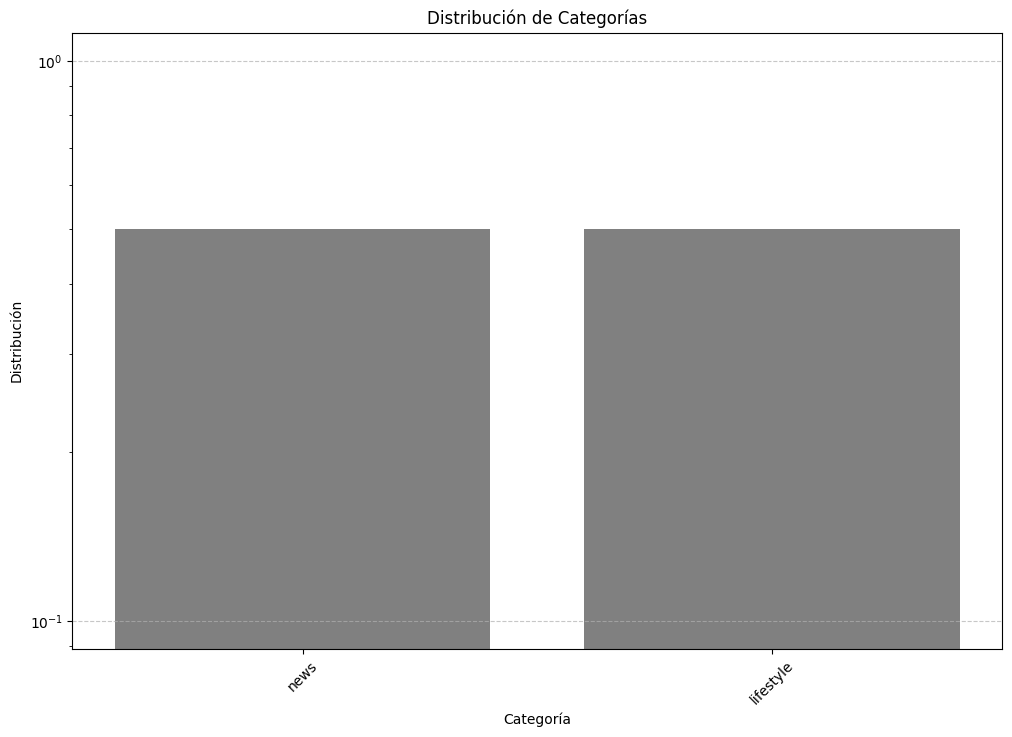

In [253]:
chart = plot_user_profile_distribution(user_profile_distribution)

## 7. Surpirse recommender

In [93]:
#Import the model svd++
from surprise import SVDpp
from surprise import Dataset, Reader

# Define the rating scale for the dataset
reader = Reader(rating_scale=(0, 5))

# Load the training data into Surprise's format
trainset = Dataset.load_from_df(
    train_df[["userId", "itemId", "rating"]], reader=reader
).build_full_trainset()

# Initialize and fit the SVD++ model
svdpp = SVDpp()
svdpp.fit(trainset)

In [95]:
import tqdm
new_predictions_svdpp = []
prediction_user_map_svdpp = {}
data_p2_svdpp = []

for user in tqdm.tqdm(sorted(test_df['userId'].unique())[:500]):
    data = {"itemId": list(set(combined_df["itemId"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["rating"] = 0.0
    user_testset_df["userId"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["userId", "itemId", "rating"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in svdpp.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    new_predictions_svdpp.append(predictions[:10])
    prediction_user_map_svdpp[user] = predictions[:10]

100%|██████████| 500/500 [09:27<00:00,  1.14s/it]


In [147]:
#funcion que grafica la distribucion de categorias consumidas por el usuario y la distribucion de categorias hechas por el sistemas de recomenacion
def plot_distribution_profile_recomendations(user_profile_distribution,user_rec_distribution_svdpp):
    plt.figure(figsize=(12, 8))
    x_map = {}
    n = 0
    for genre in user_profile_distribution:
        if genre not in x_map:
            x_map[genre] = n
            n += 2
    for genre in user_rec_distribution_svdpp:
        if genre not in x_map:
            x_map[genre] = n
            n += 2
    plt.bar(
    x=[x_map[i[0]] for i in user_profile_distribution.items()],
    height=[i[1] for i in user_profile_distribution.items()],
    color='blue', label="Perfil", width=0.8, alpha=0.6
    )

    plt.bar(
    x=[x_map[i[0]]+0.8 for i in user_rec_distribution_svdpp.items()],
    height=[i[1] for i in user_rec_distribution_svdpp.items()],
    color='gray', label="Recomendações",width=0.8
    )

    plt.xticks(rotation=45)
    plt.yscale('log')  # Escala logarítmica para valores pequeños
    plt.xlabel("Categorias")
    plt.ylabel("Presença de categorias (%)")
    plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
    plt.grid()
    plt.legend()
    plt.show()
    

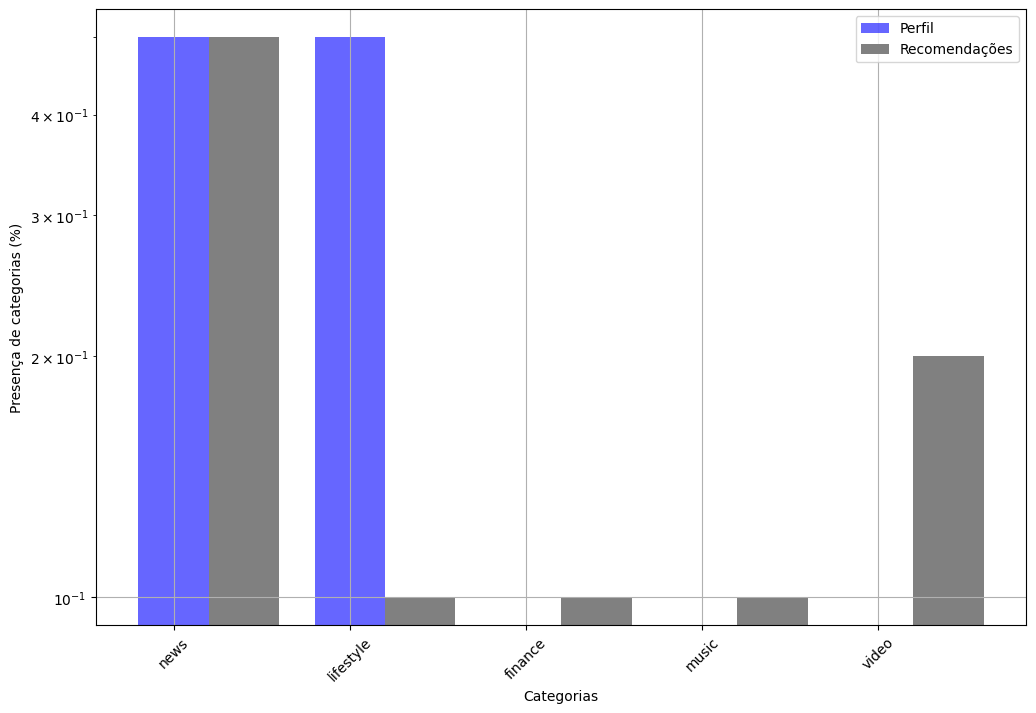

In [269]:
user_rec_distribution_svdpp = get_user_recommendation_distribution(prediction_user_map_svdpp[90])
#aqui obtnemos la distribucion del perfil del usuario peliculas consumidas por el usuario
user_profile_distribution_svdpp = get_user_profile_distribution(train_df, 90)
plot_distribution_profile_recomendations(user_profile_distribution,user_rec_distribution_svdpp)

### Metricas

In [257]:
MRMC_before_svdpp = get_mean_rank_miscalibration(prediction_user_map_svdpp)
MRMC_before_svdpp

0.5065815440256729

In [259]:
# MRR
MRR_before = calculate_MRR(prediction_user_map_svdpp)
MRR_before

0.0

## 8.Calibration

In [183]:
tradeoff = 0.5
N = 10

prediction_user_map_after_calibration_svdpp = {}

for user in tqdm.tqdm(sorted(test_df['userId'].unique())[:500]):
    
    user_profile_distribution = get_user_profile_distribution(train_df, user)
    
    data = {"itemId": list(set(combined_df["itemId"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["rating"] = 0.0
    user_testset_df["userId"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["userId", "itemId", "rating"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in svdpp.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    
    
    reranked_list = rerank_recommendation(
        user_profile_distribution,
        predictions[:100],
        user,
        N,
        tradeoff
    )
    
    prediction_user_map_after_calibration_svdpp[user] = reranked_list[1]

100%|██████████| 500/500 [09:36<00:00,  1.15s/it]


### Metrics post calibration

In [261]:
MRMC_after_svdpp = get_mean_rank_miscalibration(prediction_user_map_after_calibration_svdpp)
MRMC_after_svdpp

0.17422754271402413

In [263]:
# MRR
MRR_before_svdpp = calculate_MRR(prediction_user_map_after_calibration_svdpp)
MRR_before_svdpp

0.00025

## 9. Comparation

In [265]:
user_rec_distribution = get_user_recommendation_distribution(prediction_user_map_svdpp[90])
user_rec_distribution_after_calibration = get_user_recommendation_distribution(prediction_user_map_after_calibration_svdpp[90])
user_profile_distribution = get_user_profile_distribution(train_df, 90)

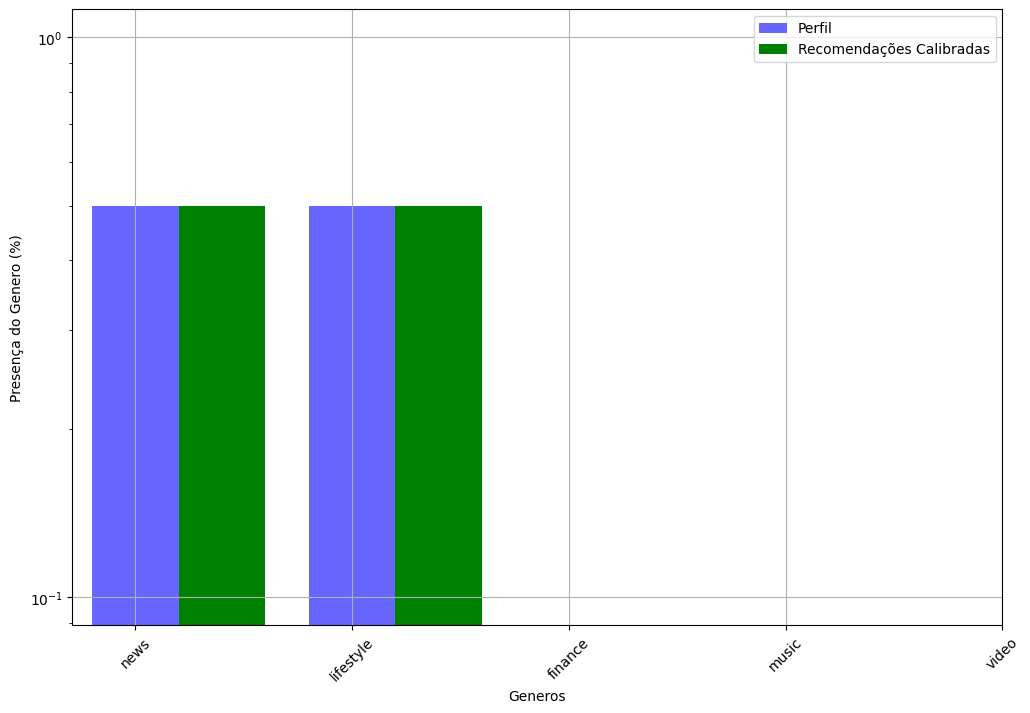

In [267]:

plt.figure(figsize=(12, 8))

x_map = {}
n = 0
for genre in user_profile_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2
for genre in user_rec_distribution:
    if genre not in x_map:
        x_map[genre] = n
        n += 2

plt.bar(
    x=[x_map[i[0]] for i in user_profile_distribution.items()],
    height=[i[1] for i in user_profile_distribution.items()],
    color='blue', label="Perfil", width=.8, alpha=0.6
)

plt.bar(
    x=[x_map[i[0]]+0.8 for i in user_rec_distribution_after_calibration.items()],
    height=[i[1] for i in user_rec_distribution_after_calibration.items()],
    color='green', label="Recomendações Calibradas",width=0.8
)

plt.xticks(rotation=45)
plt.yscale('log')  # Escala logarítmica para valores pequeños
plt.xlabel("Generos")
plt.ylabel("Presença do Genero (%)")
plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
plt.grid()
plt.legend()
plt.show()